# Installing external libraries

In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 10.4 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=584ad96da531990d37545f8a07059b4e95108661a8b5ff0a6b4029686591f2b2
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [ ]:
!pip install PTable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for PTable: filename=PTable-0.9.2-py3-none-any.whl size=22925 sha256=fc893414563075c628d08b7c2342ba5d76c264aefa31173ee9a862eb191e7f40
  Stored in directory: /root/.cache/pip/wheels/33/df/2f/674985b3f8a2de3f96357d1eadef5110f74fa91b3785e52a54
Successfully built PTable


# Imports

In [ ]:
#basic package
import numpy as np
import pandas as pd
import scipy

#nlp
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
import string
import gensim
from gensim import corpora, models
from gensim.models import LsiModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
#from pymorphy2 import MorphAnalyzer

#feature engineering
from gensim import utils
import gensim.parsing.preprocessing as gsp
from sklearn.feature_extraction.text import TfidfVectorizer

#vizualiazation
from pprint import pprint
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from prettytable import PrettyTable
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider, value, LabelSet, Legend, ColumnDataSource
from bokeh.plotting import figure, show, output_notebook, save

#settings
import os
import gc

#downloads
from google_drive_downloader import GoogleDriveDownloader as gdd

# Initiallization

In [ ]:
%matplotlib inline
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 12

output_notebook()

import warnings 
warnings.filterwarnings('ignore')

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

stopwords=nltk.corpus.stopwords.words('russian')
stopwords.extend(['что', 'это', 'так', 'вот', 'быть',
                   'как', 'на'])

# для воспроизводимости результатов
seed = 239
np.random.seed(seed)

# Auxilliary functions

In [ ]:
def text_cleaning(text):
        '''
        Функция для чистки текста. 
        Parameters:
        ----------
        text - текст, над которым производится чистка
        '''
        def strip_html_tags(text):
            '''
            Функция для удаления html tags
            '''
            soup = BeautifulSoup(text, "html.parser")
            stripped_text = soup.get_text(separator=" ")
            return stripped_text

        def remove_URL(text):
            '''
            Функция для удаления url.
            '''
            url = re.compile(r'http(s*)?://\S+|www\.\S+')
            return url.sub(r'',text)

        def remove_emoji(text):
            '''
            Функция для удаления эмоджис и эмотиконов в тексте.
            '''
            emoji_pattern = re.compile("["
                                  u"\U0001F600-\U0001F64F"  # emoticons
                                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                  u"\U00002702-\U000027B0"
                                  u"\U000024C2-\U0001F251"
                                  "]+", flags=re.UNICODE)
            return emoji_pattern.sub(r'', text)

        def remove_ip(text):
            '''
            Функция для удаления ip адресов
            '''
            text = re.sub("([0-9]{1,3}[\.]){3}[0-9]{1,3}", "", text)
            return text

        def remove_stopwords(text):
            '''
            Функция для удаления стоп-слов, а также всех не слов и отдельных букв
            text - список слов
            '''
            text = word_tokenize(text)
            text = [token for token in text if ((len(token) >= 3) and (token not in stop_words) and token.isalpha())]
            return text

        def normalization_of_text(text):
            '''
            Функция для нормализации списка
            text - список слов
            '''
            text = [morph.parse(x)[0].normal_form for x in text]
            return text

        filters = [ 
                strip_html_tags,
                remove_URL, 
                remove_emoji,
                remove_ip,
                gsp.strip_numeric, # уберем цифры
                remove_stopwords, 
                normalization_of_text
                ]

        for f in filters:
              text = f(text)
                    
        return text

In [ ]:
def compute_coherence_values(model_name, dictionary, corpus, texts, limit, start=2, step=3):
        """
        Функция для вычисления c_v coherence для различных значений k
        Parameters:
        ----------
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

        Returns:
        -------
        model_list : Список LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
        """
        
        def coherence_visual(coherence_values, limit, start, step):
            '''
            Функция для построения графика зависимости coherence_score от количества тем
            Parameters:
            ---------
            coherence_values : Coherence values corresponding to the LDA model with respective number of topics
            '''

            x = range(start, limit, step)
            plt.plot(x, coherence_values)
            plt.xlabel("Num Topics")
            plt.ylabel("Coherence score")
            plt.legend(("coherence_values"), loc='best')
            plt.show()    

            print(f'Coherence score of {model_name} for different k')
            for m, cv in zip(x, coherence_values):
                print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
                
        coherence_values = []
        model_list = []
        for num_topics in range(start, limit, step):

            if model_name == 'LDA':
                model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=2, workers=4)
            elif model_name == 'LSA':
                model = gensim.models.LsiModel(corpus, num_topics=num_topics, id2word=dictionary)

            model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_values.append(coherencemodel.get_coherence())
        
        #построим coherence matrix и выведем основные значения coherence score
        coherence_visual(coherence_values, limit, start=2, step=3)
        
        return model_list, coherence_values

In [ ]:
def model_evaluation(model, texts, dictionary):
        """
        Функция для вычисления UCI и UMass      
        Parameters:
        ----------
        model: название модели
        texts : список текстов
        dictionary : Gensim словарь
        """
        plot = PrettyTable()

        plot.field_names = ["Name", "Method", " Coherence score"]

        plot.add_row([model_name, 'c_v', np.around(CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence(), decimals = 3)])
        plot.add_row([model_name, 'u_mass', np.around(CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass').get_coherence(), decimals = 3)])

        print(plot)

In [ ]:
def tsne_plot(model):
        """
        Функция для визуализации распределения документов по темам
        Parameters:
        ----------
        model: название модели
        """
        empty_strings = [213, 3074, 3221, 5581, 28330, 33510]
        hm = np.array([[y for (x,y) in model[corpus[i]]] for i in range(len(corpus[:7000]))])
        pm = np.array([hm[i] for i in range(len(hm)) if i not in empty_strings])
        clean_tags = [df.clean_tags[i] for i in range(len(df.clean_tags[:7000])) if i not in empty_strings]
        clean_hubs = [df.clean_hubs[i] for i in range(len(df.clean_hubs[:7000])) if i not in empty_strings]

        tsne = TSNE(n_components=2, random_state=seed, angle=.99, init='pca')
        embedding = tsne.fit_transform(pm)
        embedding = pd.DataFrame(embedding, columns=['x','y'])
        embedding['topic'] = pm.argmax(axis=1)
        embedding['tags'] = clean_tags
        embedding['hubs'] = clean_hubs

        mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

        source = ColumnDataSource(
                                  data=dict(
                                            x = embedding['x'],
                                            y = embedding['y'],
                                            Topic = embedding['topic'],
                                            colors = mycolors[embedding['topic']],
                                            Tags = embedding['tags'],
                                            Hubs = embedding['hubs'],
                                          )
                                  )


        hover_tsne = HoverTool(names=["train"], 
                                tooltips=[("Topic", "@Topic"), 
                                          ("Tags", "@Tags"), 
                                          ("Hubs", "@Hubs")])

        tools_tsne = [hover_tsne, 'pan', 'wheel_zoom', 'reset']

        plot_tsne = figure(plot_width=1000, plot_height=600, tools=tools_tsne, title=f'TSNE visualization for {model_name} model: {len(model_topics)} topics')

        plot_tsne.circle('x', 'y', size=12, fill_color='colors', 
                          alpha=0.5, line_width=0, source=source, name="train")
        show(plot_tsne)

# Downloads, EDA & preprocessing

In [ ]:
https://docs.google.com/spreadsheets/d/1pV-LzVcDtjbVtE2O5SNNieeGt3iyX1HD/edit?usp=sharing&ouid=113301348016027617950&rtpof=true&sd=true

1pV-LzVcDtjbVtE2O5SNNieeGt3iyX1HD

In [ ]:
gdd.download_file_from_google_drive(file_id='1pV-LzVcDtjbVtE2O5SNNieeGt3iyX1HD',\
                                    dest_path='/Alseko/BCC/Data.xlsx')
df = pd.read_excel('/Alseko/BCC/Data.xlsx', sep=',')

NameError: ignored

In [ ]:
df.head(5)

id  ...                   Timestamp
0  353832  ...         2018-04-19 18:41:00
1  259879  ...         2015-06-09 11:39:00
2  495328  ...  2020-04-02 16:04:00.000000
3  366155  ...         2015-02-10 08:56:00
4  415371  ...         2018-06-26 22:33:00

[5 rows x 8 columns]

## EDA and preprocessing

In [ ]:
df.sample(5)

In [ ]:
df.info()

In [ ]:
df.shape

Нам не нужны столбцы id, user, user_link, Timestamp, clean_title. Удалим их

In [ ]:
df = df[['clean_text', 'clean_tags', 'clean_hubs']]
df.head(5)

In [ ]:
df.clean_text[0]

Значит, от знаком препинания уже избавились. И понизили lowercase. Осталось:

1. Из анализируемых документов исключаются стоп-слова. 

2. з анализируемых документов необходимо отфильтровать цифры, отдельные буквы и знаки препинания.

3. Исключить слова, которые встречаются во всех документах только один раз. Это не влияет на конечный результат, но сильно упрощает математические вычисления.

4. Со всеми словами из документов должна быть проведена операция стемминга – получение основы слова. (чтобы было быстрее)

Но сначала проверим, а все ли отзывы - строки

In [ ]:
not_str = []

for i in range(len(df)):
  if type(df.clean_text[i]) != str:
    not_str.append(i)

In [ ]:
print(not_str)

In [ ]:
df = df.drop(not_str, axis='index')

Найдем и удалим дубли

In [ ]:
df[df.duplicated()]

In [ ]:
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)

Теперь займемся чисткой текстов

In [ ]:
morph = MorphAnalyzer()

In [ ]:
%%time
df['clean_text'] = df['clean_text'].apply(lambda row: text_cleaning(row))

In [ ]:
df.clean_text[0]

In [ ]:
df.to_csv('h2w.prepro_1.csv')

# Download preprocessed text & prepare it

In [ ]:
gdd.download_file_from_google_drive(file_id='1LshiLfbwZ3GhzLuAEH-FjdnIHOTRwf_Y',\
                                    dest_path='/data/prepro_df.csv')
df = pd.read_csv('/data/prepro_df.csv', sep=',')

In [ ]:
gdd.download_file_from_google_drive(file_id='1enPF5DzavjgLARMArqZr3pnesrvNAg5H',\
                                    dest_path='/HW/h2w.prepro_1.csv')
df = pd.read_csv('/HW/h2w.prepro_1.csv', sep=',')

In [ ]:
df.head(5)

<!DOCTYPE html><html><head><title>Google Drive - Virus scan warning</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/><style nonce="g-QR6Co-FmujOnQghC--cg">/* Copyright 2022 Google Inc. All Rights Reserved. */
.goog-inline-block{position:relative;display:-m... sans-serif;margin:0}.grecaptcha-badge{visibilit...  .uc-warning-caption{color:#222;font-size:16px}...

In [ ]:
df = df[['clean_text', 'clean_tags', 'clean_hubs']]

KeyError: ignored

In [ ]:
df.head(5)

clean_text  ...                                         clean_hubs
0  ['следующий', 'год', 'год', 'момент', 'создани...  ...  ['информационная_безопасность', 'системное_адм...
1  ['sdk', 'magic', 'leap', 'скорокомпания', 'mag...  ...  ['разработка_мобильных_приложений', 'разработк...
2  ['публиковать', 'перевод', 'статья', 'который'...  ...  ['программирование', 'git', 'системы_управлени...
3  ['будущее', 'электронный', 'торговля', 'здесьп...  ...             ['управление_e-commerce', 'периферия']
4  ['рамка', 'дать', 'статья', 'постараться', 'да...  ...  ['информационная_безопасность', 'платежные_сис...

[5 rows x 3 columns]

In [ ]:
%%time

df['clean_text'] = df['clean_text'].apply(lambda row: eval(row))
df['clean_tags'] = df['clean_tags'].apply(lambda row: eval(row))
df['clean_hubs'] = df['clean_hubs'].apply(lambda row: eval(row))

CPU times: user 59.4 s, sys: 5.41 s, total: 1min 4s
Wall time: 1min 4s


In [ ]:
empty_strings = []

for i in range(len(df)):
     if df.clean_text[i] == []:
          empty_strings.append(i)

empty_strings

[213, 3074, 3221, 5581, 28330, 33510]

In [ ]:
df = df[:25000]

# Models

В данном разделе мы сравним три модели между собой:
*   LSA
*   LDA
*   ARTM

Для каждой из модели мы сначала посчитаем оптимальное количество тем - k. Этот показатель является эмпирическим и существует большое количество способов его вычисления. 

Сравнение будет проходить по метрикам:
*   UCI
*   UMass

Также для каждой модели будет построена интерактивная TSNE-визуализация (существует более популярный вариант для LDA - pyLDAvis, но мы отдадим первенство более универсальному способу).


## Creating corpus

In [ ]:
dictionary = gensim.corpora.Dictionary(df['clean_text'])
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=None)

In [ ]:
print('Размер словаря =', len(dictionary))

Размер словаря = 32045


In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in df['clean_text']]

In [ ]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.16972704132942265),
 (1, 0.03871219813559799),
 (2, 0.17874341139808805),
 (3, 0.06983039521844835),
 (4, 0.0361198784318087),
 (5, 0.43315048143235674),
 (6, 0.17268862227785053),
 (7, 0.1771719946752163),
 (8, 0.1487716099452971),
 (9, 0.04772164221160298),
 (10, 0.06339923130242003),
 (11, 0.025029546777154056),
 (12, 0.03967292452492321),
 (13, 0.16453129638956418),
 (14, 0.031045332068458033),
 (15, 0.03961601568818107),
 (16, 0.2422037059041426),
 (17, 0.034824216651570296),
 (18, 0.03825367278731779),
 (19, 0.05721245129794204),
 (20, 0.041747995385842604),
 (21, 0.041338783578209144),
 (22, 0.03570681663035171),
 (23, 0.07801521787535644),
 (24, 0.0344483855610537),
 (25, 0.09501553606773927),
 (26, 0.12010352391675767),
 (27, 0.05958113713269601),
 (28, 0.055375155825860584),
 (29, 0.04797936605760008),
 (30, 0.03566767413166724),
 (31, 0.05510517449479266),
 (32, 0.02234018059869688),
 (33, 0.04409921845076164),
 (34, 0.04852216049600643),
 (35, 0.3048444769544389),
 (

In [ ]:
corpus=corpus_tfidf
texts=df['clean_text']

## LSA

In [ ]:
model_name = 'LSA'

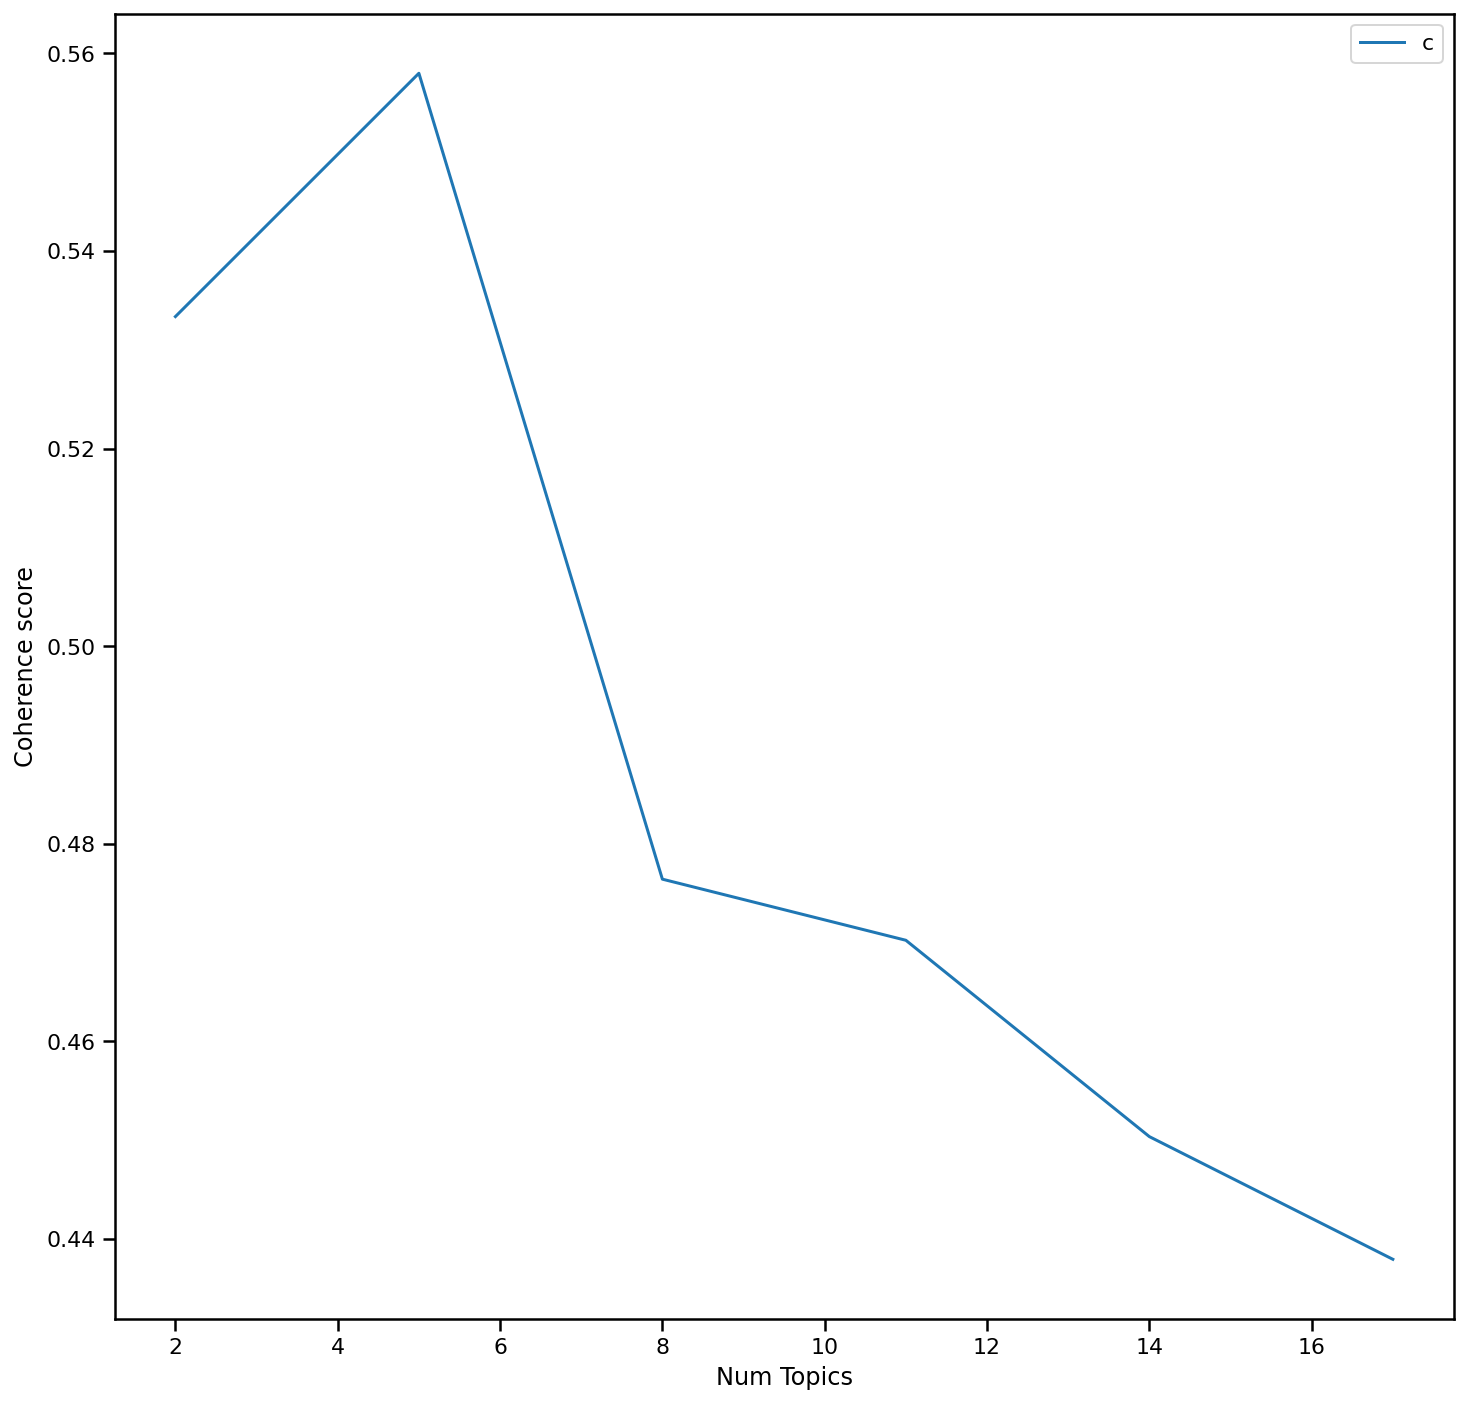

Coherence score of LSA for different k
Num Topics = 2  has Coherence Value of 0.5334
Num Topics = 5  has Coherence Value of 0.558
Num Topics = 8  has Coherence Value of 0.4764
Num Topics = 11  has Coherence Value of 0.4702
Num Topics = 14  has Coherence Value of 0.4504
Num Topics = 17  has Coherence Value of 0.4379
CPU times: user 7min 29s, sys: 44.7 s, total: 8min 14s
Wall time: 19min 37s


In [ ]:
%%time

model_list, coherence_values = compute_coherence_values(model_name, dictionary=dictionary, corpus=corpus, texts=texts, start=2, limit=20, step=3)

In [ ]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.099*"приложение" + 0.087*"пользователь" + 0.086*"компания" + '
  '0.082*"проект" + 0.081*"код" + 0.080*"человек" + 0.078*"игра" + '
  '0.075*"данные" + 0.074*"файл" + 0.073*"клиент"'),
 (1,
  '0.375*"the" + 0.175*"and" + 0.173*"return" + 0.131*"for" + 0.128*"public" + '
  '0.117*"файл" + 0.110*"int" + 0.109*"that" + 0.108*"you" + 0.107*"new"'),
 (2,
  '-0.534*"the" + -0.241*"and" + -0.163*"you" + -0.162*"that" + 0.129*"файл" + '
  '-0.108*"are" + -0.108*"with" + -0.103*"for" + -0.099*"this" + -0.099*"can"'),
 (3,
  '-0.201*"игра" + 0.163*"сервер" + 0.139*"пользователь" + 0.124*"windows" + '
  '0.120*"уязвимость" + 0.119*"сервис" + 0.111*"приложение" + 0.103*"клиент" + '
  '0.103*"пароль" + 0.101*"сайт"'),
 (4,
  '0.165*"устройство" + -0.147*"доклад" + 0.126*"камера" + '
  '-0.094*"конференция" + 0.094*"смартфон" + 0.093*"датчик" + '
  '0.091*"космический" + 0.090*"процессор" + 0.090*"плата" + 0.086*"аппарат"')]


In [ ]:
len(model_topics)

5

In [ ]:
model_evaluation(optimal_model, texts, dictionary)

+------+--------+------------------+
| Name | Method |  Coherence score |
+------+--------+------------------+
| LSA  |  c_v   |      0.558       |
| LSA  | u_mass |      -1.512      |
+------+--------+------------------+


In [ ]:
model_name = 'LSA'
optimal_model= gensim.models.LsiModel(corpus, num_topics=5, id2word=dictionary)

In [ ]:
tsne_plot(optimal_model)

## LDA

In [ ]:
model_name = 'LDA'

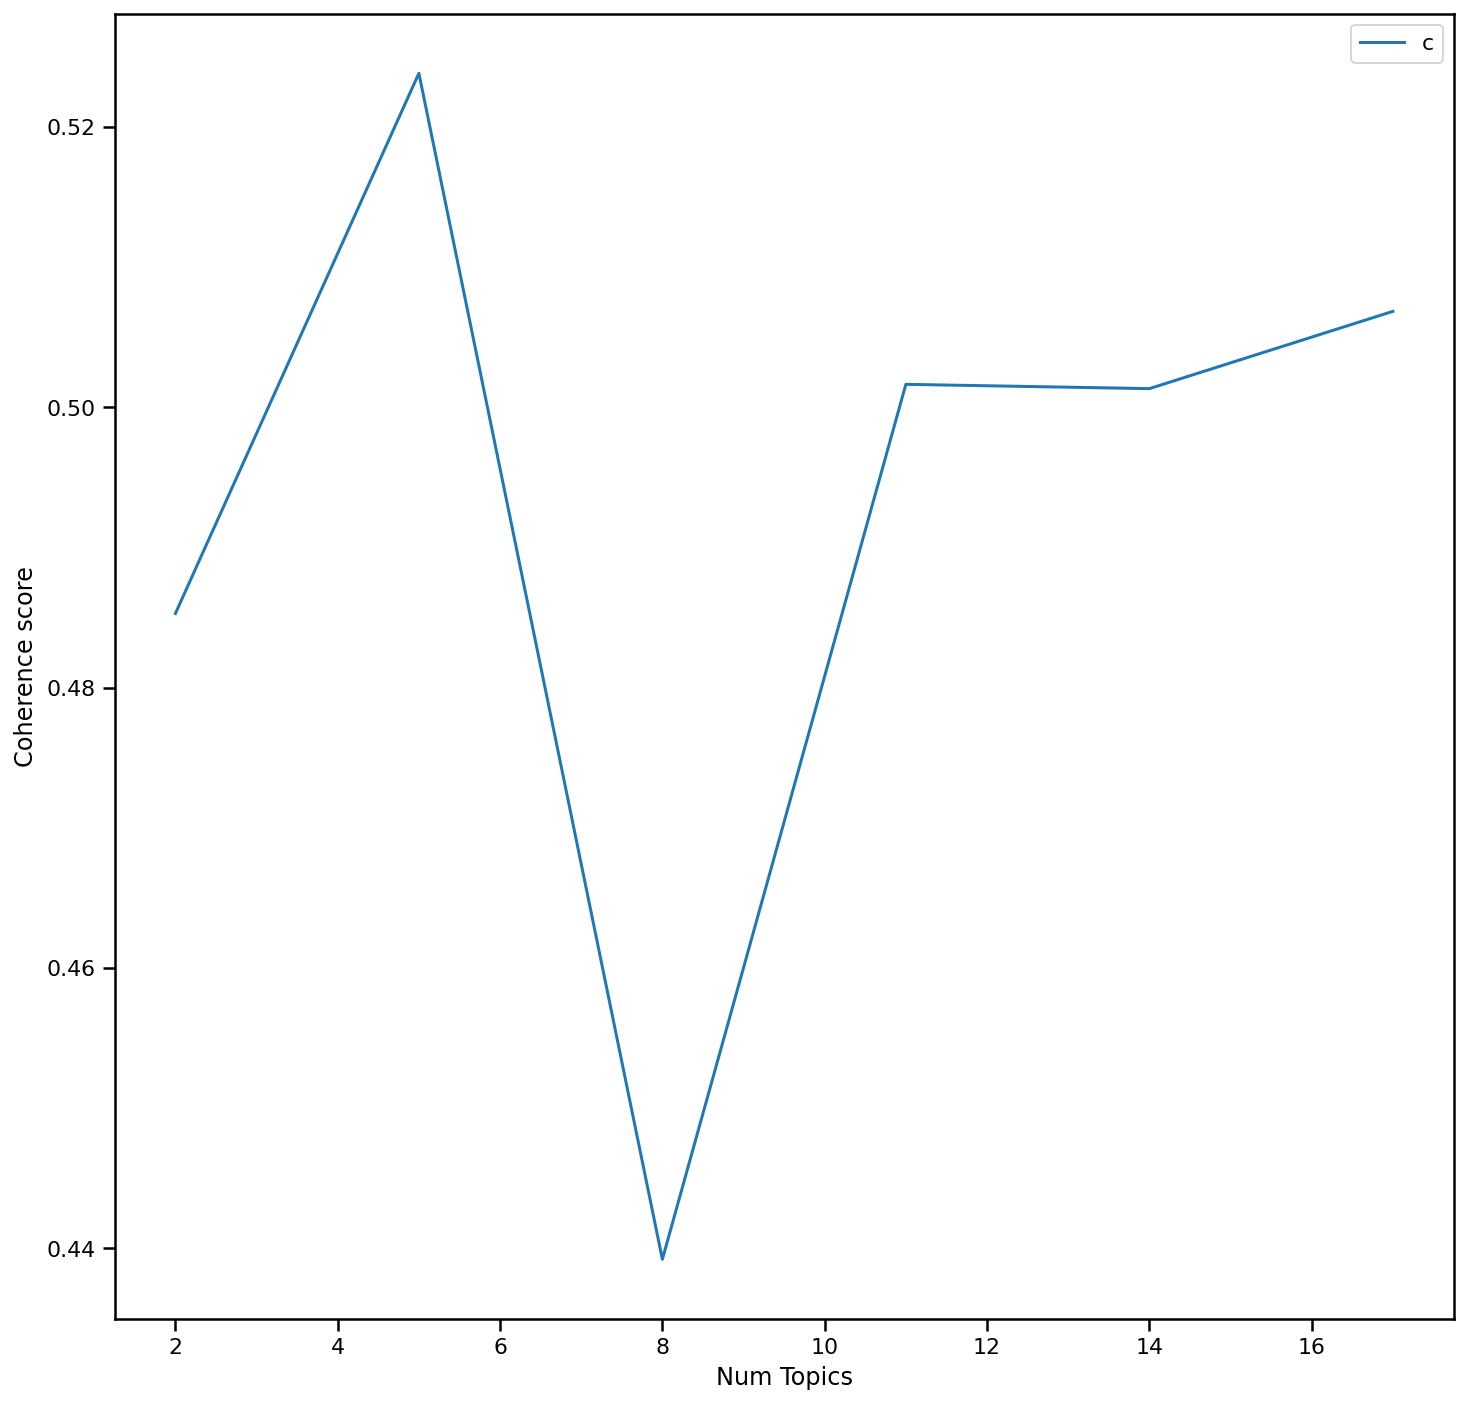

Coherence score of LDA for different k
Num Topics = 2  has Coherence Value of 0.4853
Num Topics = 5  has Coherence Value of 0.5238
Num Topics = 8  has Coherence Value of 0.4392
Num Topics = 11  has Coherence Value of 0.5016
Num Topics = 14  has Coherence Value of 0.5013
Num Topics = 17  has Coherence Value of 0.5068
CPU times: user 20min 2s, sys: 1min 30s, total: 21min 32s
Wall time: 35min 47s


In [ ]:
%%time

model_list, coherence_values = compute_coherence_values(model_name, dictionary=dictionary, corpus=corpus, texts=texts, start=2, limit=20, step=3)

In [ ]:
optimal_model = gensim.models.LdaMulticore(corpus, num_topics=11, id2word=dictionary, passes=2, workers=4)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.002*"российский" + 0.002*"компания" + 0.002*"закон" + 0.002*"суд" + '
  '0.002*"млрд" + 0.002*"млн" + 0.002*"россия" + 0.002*"законопроект" + '
  '0.001*"оператор" + 0.001*"договор"'),
 (1,
  '0.001*"ceph" + 0.001*"midi" + 0.001*"location" + 0.001*"google" + '
  '0.001*"приложение" + 0.001*"uber" + 0.001*"the" + 0.001*"хаба" + '
  '0.001*"пользователь" + 0.001*"клиент"'),
 (2,
  '0.004*"космический" + 0.003*"спутник" + 0.003*"корабль" + 0.003*"марс" + '
  '0.003*"ракета" + 0.003*"орбита" + 0.003*"луна" + 0.002*"аппарат" + '
  '0.002*"полёт" + 0.002*"мкс"'),
 (3,
  '0.008*"the" + 0.003*"and" + 0.002*"you" + 0.002*"that" + 0.002*"for" + '
  '0.002*"with" + 0.002*"this" + 0.002*"сертификат" + 0.002*"can" + '
  '0.001*"are"'),
 (4,
  '0.003*"игра" + 0.002*"игрок" + 0.001*"файл" + 0.001*"приложение" + '
  '0.001*"цвет" + 0.001*"устройство" + 0.001*"кнопка" + 0.001*"шрифт" + '
  '0.001*"проект" + 0.001*"экран"'),
 (5,
  '0.004*"return" + 0.003*"файл" + 0.003*"int" + 0.003*"public" 

In [ ]:
model_evaluation(optimal_model, texts, dictionary)

+------+--------+------------------+
| Name | Method |  Coherence score |
+------+--------+------------------+
| LDA  |  c_v   |      0.514       |
| LDA  | u_mass |      -3.275      |
+------+--------+------------------+


In [ ]:
tsne_plot(optimal_model)